In [38]:
import os
import re
import time

import pandas as pd
import numpy as np

from glob import glob

from scipy.fftpack import fft
from scipy.io import wavfile
from scipy import signal

from keras.models import Model
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization                         
from keras.optimizers import Adam
from keras.callbacks import TensorBoard

from sklearn.preprocessing import LabelBinarizer
from pathlib import Path

import matplotlib.pyplot as plt
import IPython.display as ipd
%matplotlib inline

# Dataset investigation

In [4]:
all_files = glob('./../raw_data/train/audio/*/*wav')

In [5]:
len(all_files)

64727

In [20]:
all_files[8000]

'./../raw_data/train/audio/cat/8056e897_nohash_0.wav'

In [42]:
filename = "./../raw_data/train/audio/yes/0a7c2a8d_nohash_0.wav" # all_files[8000]
sample_rate, samples = wavfile.read(filename)

In [43]:
sample_rate, samples

(16000, array([ 14,  -7, -14, ...,  19,  20,  27], dtype=int16))

In [44]:
ipd.Audio(samples, rate=sample_rate)

In [104]:
freqs, times, spectrogram = signal.spectrogram(samples, 
                                               fs=sample_rate,
                                               nperseg=320,
                                               window='hann',
                                               noverlap=160,
                                               detrend=False)

In [105]:
spectrogram

array([[  1.13694195e-03,   1.73456647e-05,   1.34958667e-04, ...,
          1.11096760e-03,   1.46731363e-05,   1.65873325e-06],
       [  4.68051992e-03,   8.68044328e-04,   1.97302420e-02, ...,
          5.50470664e-04,   1.39065215e-03,   1.00339532e-01],
       [  2.20795095e-01,   2.07831308e-01,   2.38598123e-01, ...,
          4.72181231e-01,   3.91887724e-01,   3.14261377e-01],
       ..., 
       [  2.15484451e-05,   7.16087379e-06,   2.09751070e-05, ...,
          3.50522919e-06,   2.87709445e-05,   2.01075836e-05],
       [  2.52843483e-06,   2.15248451e-06,   2.02887204e-05, ...,
          1.56856390e-06,   1.00822845e-05,   3.03338838e-05],
       [  6.25227443e-08,   7.14766372e-07,   6.70569398e-06, ...,
          2.94175322e-07,   3.95711226e-07,   2.29243014e-05]], dtype=float32)

In [106]:
spectrogram.shape

(161, 99)

In [88]:
def log_specgram(audio, sample_rate, window_size=20, step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

In [89]:
log_freqs, log_times, log_spectrogram = log_specgram(samples, sample_rate)

In [90]:
log_spectrogram

array([[ -6.77941322,  -5.36434603,  -1.51052022, ..., -10.74520206,
        -12.88787079, -16.58613777],
       [-10.96216202,  -7.04926777,  -1.57102859, ..., -11.8468647 ,
        -13.04884148, -14.15116978],
       [ -8.91054153,  -3.92560267,  -1.43297458, ..., -10.77216911,
        -10.8054409 , -11.91253853],
       ..., 
       [ -6.80252361,  -7.5047369 ,  -0.75039238, ..., -12.56122589,
        -13.36528587, -15.03874969],
       [-11.12948513,  -6.57798243,  -0.93677992, ..., -10.45614147,
        -11.50472069, -14.74232864],
       [-13.30939579,  -2.29919553,  -1.15753019, ..., -10.8144083 ,
        -10.40324211, -10.6833086 ]], dtype=float32)

In [91]:
log_spectrogram.shape

(99, 161)

In [108]:
def custom_fft(y, fs):
    T = 1.0 / fs
    N = y.shape[0]
    yf = fft(y)
    xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    vals = 2.0 / N * np.abs(yf[0:N//2])  # FFT is simmetrical, so we take just the first half
    # FFT is also complex, to we take just the real part (abs)
    return xf, vals

In [109]:
fft_xf, fft_vals = custom_fft(samples, sample_rate)

Text(0.5,0,'Frequency')

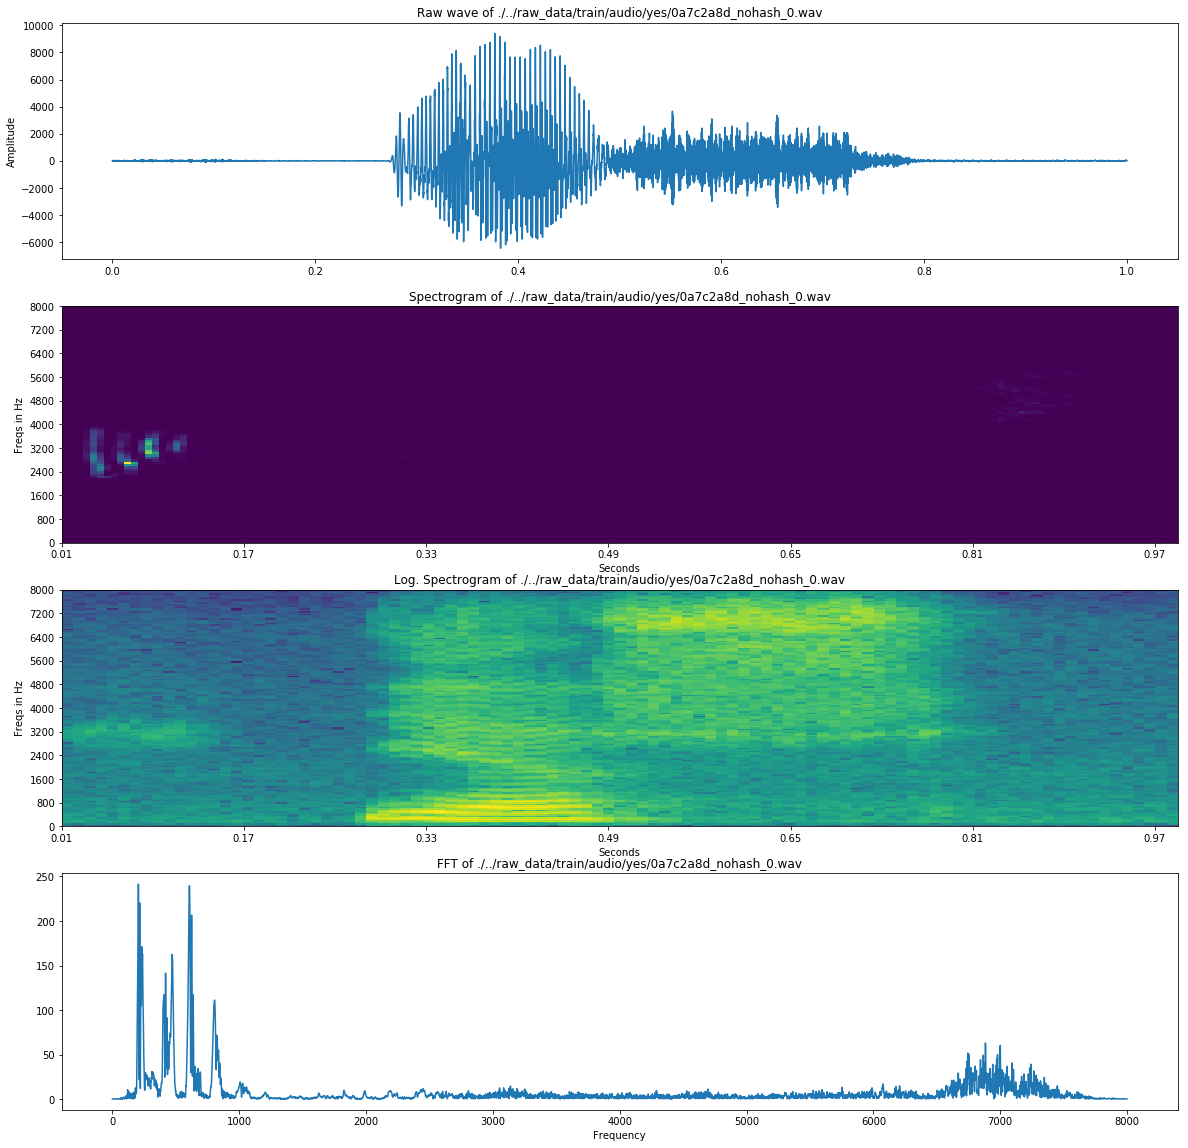

In [113]:
fig = plt.figure(figsize=(20, 20))

ax1 = fig.add_subplot(411)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate / len(samples), sample_rate), samples)

ax2 = fig.add_subplot(412)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower',
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

ax3 = fig.add_subplot(413)
ax3.imshow(log_spectrogram.T, aspect='auto', origin='lower',
           extent=[log_times.min(), log_times.max(), log_freqs.min(), log_freqs.max()])
ax3.set_yticks(log_freqs[::16])
ax3.set_xticks(log_times[::16])
ax3.set_title('Log. Spectrogram of ' + filename)
ax3.set_ylabel('Freqs in Hz')
ax3.set_xlabel('Seconds')


ax4 = fig.add_subplot(414)
ax4.set_title('FFT of ' + filename)
ax4.plot(fft_xf, fft_vals)
ax4.set_xlabel('Frequency')

In [ ]:
# IDEA:
# what if we select clean wavs from the DS
# augment them with different noise (esp. with those which make CNN-on-spec approach work much worse)
# train modified-WaveNet to denoise input
# and then we do, for any wav X: denoise(X) => CNN-on-spec => label
# too complex?